# Timeseries Forecasting of Bitcoin prices

In this exploration, I make an attempt to train recurrent neural networks to predict the price of bitcoin.

## Importing Libraries and Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bitcoin_data = pd.read_csv('BTC USD Historical Data.csv')
bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 09, 2018","14,423.00","14,902.00","15,355.00","14,122.00",43.44K,-3.40
1,"Jan 08, 2018","14,930.00","16,216.00","16,279.00","13,760.00",64.95K,-7.82
2,"Jan 07, 2018","16,196.00","17,163.00","17,176.00","15,726.00",30.84K,-5.62
3,"Jan 06, 2018","17,161.00","16,911.00","17,252.00","16,251.00",29.61K,1.44
4,"Jan 05, 2018","16,917.00","15,159.00","17,101.00","14,769.00",54.63K,11.59


In [3]:
bitcoin_data = bitcoin_data.iloc[::-1]
bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
2153,NaN,"Highest:19,891.00",Lowest:0.00,"Difference:19,891.00",Average:995.73,"Change %:237,120.40",NaN
2152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2151,"Feb 02, 2012",6.10,6.10,6.10,6.10,0,0.33
2150,"Feb 03, 2012",5.96,5.96,5.96,5.96,0,-2.30
2149,"Feb 04, 2012",5.87,5.87,5.87,5.87,0,-1.51


In [4]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 2153 to 0
Data columns (total 7 columns):
Date        2152 non-null object
Price       2153 non-null object
Open        2153 non-null object
High        2153 non-null object
Low         2153 non-null object
Vol.        2153 non-null object
Change %    2152 non-null float64
dtypes: float64(1), object(6)
memory usage: 117.9+ KB


In [5]:
from pandas import datetime
bitcoin_data['Date'] = bitcoin_data['Date'].apply(lambda date: pd.to_datetime(date))

In [6]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 2153 to 0
Data columns (total 7 columns):
Date        2152 non-null datetime64[ns]
Price       2153 non-null object
Open        2153 non-null object
High        2153 non-null object
Low         2153 non-null object
Vol.        2153 non-null object
Change %    2152 non-null float64
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 117.9+ KB


In [7]:
bitcoin_data[pd.isnull(bitcoin_data).any(axis=1)]

,Date,Price,Open,High,Low,Vol.,Change %
2153,NaT,"Highest:19,891.00",Lowest:0.00,"Difference:19,891.00",Average:995.73,"Change %:237,120.40",NaN
2152,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
bitcoin_data.dropna(axis=0, inplace=True)

In [9]:
bitcoin_data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [10]:
import locale
from locale import *
locale.setlocale(locale.LC_NUMERIC, '')
bitcoin_data['Price'] = bitcoin_data['Price'].apply(lambda x: atof(x))

In [11]:
bitcoin_data['Open'] = bitcoin_data['Price'].apply(lambda x: float(x))
bitcoin_data['High'] = bitcoin_data['Price'].apply(lambda x: float(x))
bitcoin_data['Low'] = bitcoin_data['Price'].apply(lambda x: float(x))

In [12]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152 entries, 2151 to 0
Data columns (total 7 columns):
Date        2152 non-null datetime64[ns]
Price       2152 non-null float64
Open        2152 non-null float64
High        2152 non-null float64
Low         2152 non-null float64
Vol.        2152 non-null object
Change %    2152 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 134.5+ KB


## Visualizing Bitcoin prices over a 6-year period

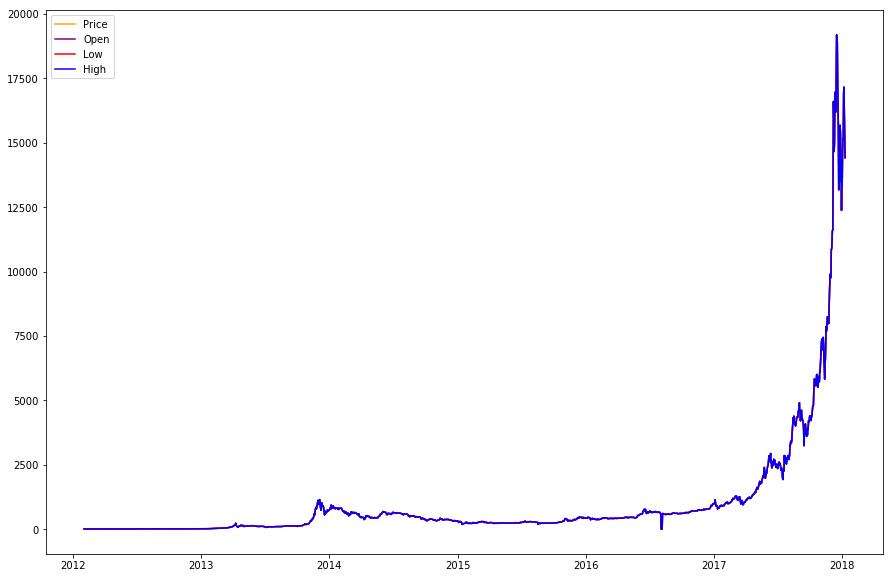

In [13]:
plt.plot(bitcoin_data['Date'], bitcoin_data['Price'], color = 'orange')
plt.plot(bitcoin_data['Date'], bitcoin_data['Open'], color='purple')
plt.plot(bitcoin_data['Date'], bitcoin_data['Low'], color='red')
plt.plot(bitcoin_data['Date'], bitcoin_data['High'], color='blue')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

## Using TensorFlow to Train RNNs

In [14]:
import tensorflow as tf

In [15]:
bitcoin_data = bitcoin_data.set_index('Date')

In [16]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2152 entries, 2012-02-02 to 2018-01-09
Data columns (total 6 columns):
Price       2152 non-null float64
Open        2152 non-null float64
High        2152 non-null float64
Low         2152 non-null float64
Vol.        2152 non-null object
Change %    2152 non-null float64
dtypes: float64(5), object(1)
memory usage: 117.7+ KB


In [17]:
train_data_price = bitcoin_data['Price'].iloc[:-30] # We give the model about 5 years and 11 months of training data
# Everything except the last month of data is used for training
test_data_price = bitcoin_data['Price'].tail(30) 

### Scaling the Data
In order to train a neural network on this data, it is a good idea to scale it first.

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
train_data_price_scaled = scaler.fit_transform(train_data_price)
test_data_price_scaled = scaler.transform(test_data_price)

//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

## Setting Up Our RNN Model

### Defining a function for selecting batches

In [21]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    start = np.random.randint(0, len(training_data)-steps)
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch = np.array(training_data[start:start + steps + 1]).reshape(1, steps+1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # We need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)

In [28]:
# Constants corresponding to hyperparameters for neural network

num_inputs = 1

num_time_steps = 30

num_neurons = 100

num_outputs = 1

learning_rate = 0.001

num_epochs = 8000

batch_size = 1

In [23]:
X = tf.placeholder(tf.float32, shape=[None, num_time_steps,num_inputs])
y = tf.placeholder(tf.float32, shape=[None, num_time_steps,num_outputs])

In [24]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)  # An RNN cell with 100 neurons

In [25]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)  # This keeps track of outputs and states for us

In [26]:
loss = tf.reduce_mean(tf.square(outputs - y))  # MSE Loss Function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # Adam Optimizer that gradually slows learning rate
train = optimizer.minimize(loss) # the train operation minimizes the loss function

In [27]:
init = tf.global_variables_initializer()

In [29]:
saver = tf.train.Saver()

In [30]:
with tf.Session() as sess:
    
    sess.run(init) # Initializes variables
    
    for epoch in range(num_epochs):
        
        X_batch, y_batch = next_batch(train_data_price_scaled, batch_size, num_time_steps) # Generates a random batch
        sess.run(train, feed_dict={X: X_batch, y: y_batch}) # Trains on the data from batch
        
        if epoch % 100 == 0: # Every 100 epochs 
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(epoch, "\tMSE:", mse)
        
        saver.save(sess, "./bitcoin_price_model")

0 	MSE: 0.00076324
100 	MSE: 0.00144411
200 	MSE: 0.000473154
300 	MSE: 0.000181088
400 	MSE: 7.39665e-05
500 	MSE: 9.92496e-05
600 	MSE: 0.000100745
700 	MSE: 9.93253e-05
800 	MSE: 2.08438e-05
900 	MSE: 0.000179263
1000 	MSE: 5.98656e-05
1100 	MSE: 5.08271e-05
1200 	MSE: 1.46945e-05
1300 	MSE: 3.00945e-05
1400 	MSE: 0.000760767
1500 	MSE: 3.05419e-05
1600 	MSE: 3.08152e-05
1700 	MSE: 1.3214e-05
1800 	MSE: 5.61715e-06
1900 	MSE: 1.05927e-05
2000 	MSE: 2.93124e-05
2100 	MSE: 1.5545e-05
2200 	MSE: 2.62248e-05
2300 	MSE: 1.46195e-05
2400 	MSE: 8.52934e-06
2500 	MSE: 2.04124e-05
2600 	MSE: 2.55273e-05
2700 	MSE: 2.8347e-06
2800 	MSE: 1.92026e-05
2900 	MSE: 1.54249e-05
3000 	MSE: 6.71476e-06
3100 	MSE: 1.14972e-05
3200 	MSE: 1.03155e-05
3300 	MSE: 3.82096e-06
3400 	MSE: 3.88506e-05
3500 	MSE: 7.15477e-06
3600 	MSE: 1.19931e-05
3700 	MSE: 1.70681e-05
3800 	MSE: 0.000156439
3900 	MSE: 1.46866e-05
4000 	MSE: 4.08804e-06
4100 	MSE: 5.19909e-06
4200 	MSE: 3.98714e-06
4300 	MSE: 0.00260898
4400 	

In [33]:
with tf.Session() as sess:
    
    saver.restore(sess, "./bitcoin_price_model")
    
    start_epochs = 8000
    more_epochs = 10000
    
    for epoch in range(start_epochs, more_epochs):
        
        X_batch, y_batch = next_batch(train_data_price_scaled, batch_size, num_time_steps) # Generates a random batch
        sess.run(train, feed_dict={X: X_batch, y: y_batch}) # Trains on the data from batch
        
        if epoch % 100 == 0: # Every 100 epochs 
        
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(epoch, "\tMSE:", mse)
        
    saver.save(sess, "./bitcoin_price_model")

INFO:tensorflow:Restoring parameters from ./bitcoin_price_model
4000 	MSE: 2.97187e-05
4100 	MSE: 7.11961e-06
4200 	MSE: 3.4838e-05
4300 	MSE: 1.0455e-05
4400 	MSE: 0.000110177
4500 	MSE: 4.49945e-07
4600 	MSE: 0.00104013
4700 	MSE: 0.000771948
4800 	MSE: 5.04017e-07
4900 	MSE: 0.00102343
5000 	MSE: 3.62853e-05
5100 	MSE: 3.93139e-05
5200 	MSE: 3.2841e-05
5300 	MSE: 1.0205e-05
5400 	MSE: 1.01601e-05
5500 	MSE: 2.85234e-05
5600 	MSE: 4.62422e-05
5700 	MSE: 6.73774e-07
5800 	MSE: 3.35812e-05
5900 	MSE: 5.85883e-06
6000 	MSE: 1.1912e-06
6100 	MSE: 1.07122e-06
6200 	MSE: 6.07615e-06
6300 	MSE: 9.56687e-05
6400 	MSE: 1.42599e-05
6500 	MSE: 1.10745e-05
6600 	MSE: 0.000880759
6700 	MSE: 0.000284453
6800 	MSE: 1.11249e-05
6900 	MSE: 7.52368e-07
7000 	MSE: 5.26416e-06
7100 	MSE: 0.000202085
7200 	MSE: 2.30181e-06
7300 	MSE: 5.00633e-06
7400 	MSE: 7.2738e-06
7500 	MSE: 6.09811e-06
7600 	MSE: 3.40994e-06
7700 	MSE: 1.69732e-05
7800 	MSE: 9.13865e-06
7900 	MSE: 3.63896e-06
8000 	MSE: 2.25709e-05
8

### Generating Predictions for 30 days outside of training data

In [31]:
with tf.Session() as sess:
    
    saver.restore(sess, "./bitcoin_price_model")
    
    train_seed = list(train_data_price_scaled[-30:]) # Use the last 30 days of bitcoin price data
    
    for iteration in range(30):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./bitcoin_price_model


In [32]:
results = scaler.inverse_transform(np.array(train_seed[30:]).reshape(30,1))

In [33]:
test_data_price

Date
2017-12-11    16754.00
2017-12-12    16967.00
2017-12-13    16181.00
2017-12-14    16383.00
2017-12-15    17522.00
2017-12-16    19187.00
2017-12-17    18971.00
2017-12-18    18934.00
2017-12-19    17345.00
2017-12-20    16425.00
2017-12-21    15666.83
2017-12-22    13170.00
2017-12-23    14035.00
2017-12-24    13476.00
2017-12-25    13623.00
2017-12-26    15679.00
2017-12-27    15374.00
2017-12-28    14315.00
2017-12-29    14317.00
2017-12-30    12377.00
2017-12-31    13800.00
2018-01-01    13354.00
2018-01-02    14709.82
2018-01-03    15155.00
2018-01-04    15160.00
2018-01-05    16917.00
2018-01-06    17161.00
2018-01-07    16196.00
2018-01-08    14930.00
2018-01-09    14423.00
Name: Price, dtype: float64

In [33]:
test_data_price['Predictions'] = results

In [34]:
results.shape

(120, 1)

In [34]:
test_data_price_pred = pd.DataFrame({'Date': test_data_price.index})

In [35]:
test_data_price_pred['Price'] = test_data_price.values

In [36]:
test_data_price_pred

,Date,Price
0,2017-12-11,16754.00
1,2017-12-12,16967.00
2,2017-12-13,16181.00
3,2017-12-14,16383.00
4,2017-12-15,17522.00
5,2017-12-16,19187.00
6,2017-12-17,18971.00
7,2017-12-18,18934.00
8,2017-12-19,17345.00
9,2017-12-20,16425.00


In [46]:
test_data_price_pred.drop([120], inplace = True)

In [37]:
test_data_price_pred['Prediction'] = results

In [38]:
test_data_price_pred

,Date,Price,Prediction
0,2017-12-11,16754.00,14911.989258
1,2017-12-12,16967.00,14959.208984
2,2017-12-13,16181.00,14984.668945
3,2017-12-14,16383.00,14987.231445
4,2017-12-15,17522.00,14968.836914
5,2017-12-16,19187.00,14933.914062
6,2017-12-17,18971.00,14887.027344
7,2017-12-18,18934.00,14832.079102
8,2017-12-19,17345.00,14772.169922
9,2017-12-20,16425.00,14709.693359


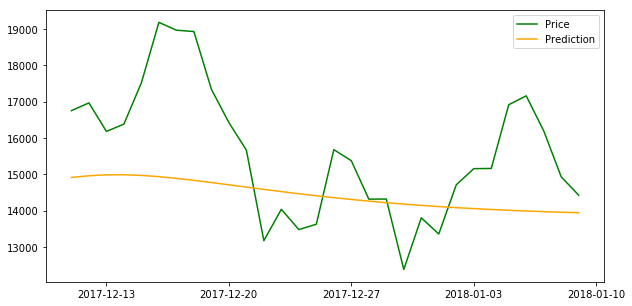

In [39]:
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Price'], color='green')
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Prediction'], color='orange')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

## Looking at Other Cryptocurrencies